<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week19_deeplearning_nlp/ch19_5_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch19_5 LSTM

이전 챕터에서는 가장 기본적인 형태의 RNN에 대해서 배워봤습니다.  하지만 바닐라 RNN은 바닐라 RNN의 시점(time step)이 길어질 수록 앞의 정보가 뒤로 충분히 전달되지 못하는 현상이 발생합니다. 즉, 시퀀스가 길어질 수록 과거의 정보가 손실되는 문제가 있습니다.

이를 보완하는 모델이 LSTM입니다. 이는 장기 기억으로 필요한 정보는 유지하고, 불필요한 기억은 삭제할 수 있는 게이트라는 개념을 RNN에 추가한 것입니다. 장기 기억을 효과적으로 보존하여 자연어 처리와 시계열 분석에 널리 사용됩니다.

## LSTM 이론

### LSTM 기본 구조

LSTM은 vanila RNN과 기본 구조는 비슷합니다. 각 시점 별로 입력 값에 대해서 예측값과 hidden state를 계산하여 다음 상태에 전달합니다.

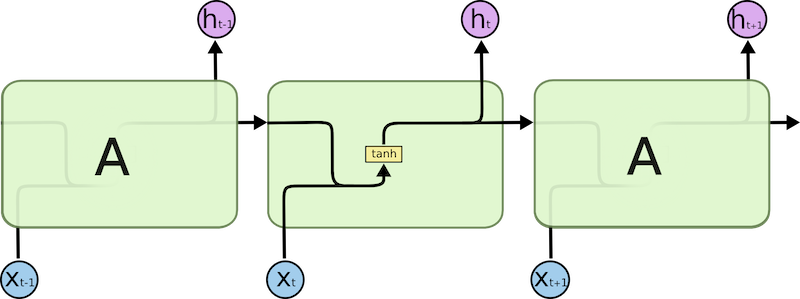

이제 LSTM의 내부 구조를 살펴보겠습니다.

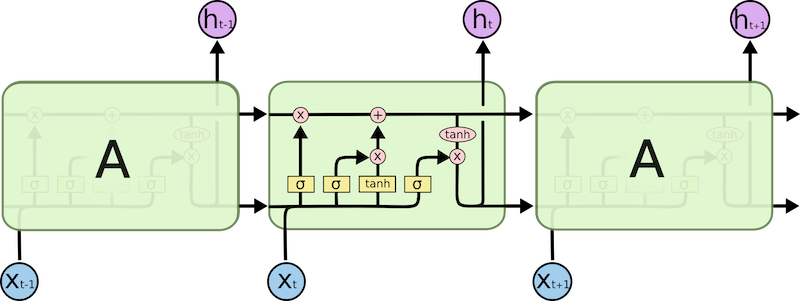

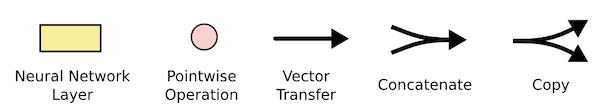

매우 복잡하게 생겼습니다만, 걱정할 필요가 없습니다. 일일이 암기할 필요는 없고, 핵심적인 개념만 숙지하겠습니다.



### Gate

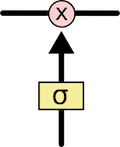

먼저 LSTM은 3가지 게이트를 이용해서 어떤 정보를 망각하고, 기억할 지를 결정합니다. 위 그림에서 𝜎로 표기된 것은 sigmoid 함수입니다. 총 3개의 sigmoid 함수를 사용하고 각각은 "망각", "기억", "출력"을 의마합니다. 즉, LSTM은 어떤 정보를 잊어버리고, 어떤 정보는 기억할 지를 이 Gate를 이용하여 학습시킵니다. 각 게이트별 세부 내용은 아래서 설명하겠습니다.

### Cell State

먼저 LSTM은 다음 시점에 cell state와 hidden state 2가지 값을 전달합니다. 먼저 cell state는 이전 시점으로부터 상태 값을 받아와서 "망각"과 "기억" 과정을 거쳐서 다음 상태로 전달되는 값입니다.

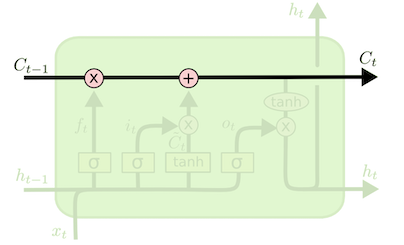

### forget gate

먼저 망각 게이트입니다. 이는 현재 시점의 입력과 이전 시점의 hidden state를 입력으로 받아서 linear layer와 sigmoid를 통과시켜줍니다. sigmoid를 통과했으니 값이 0과 1 사이가 됩니다. 이를 이전 시점의 cell state에 곱해주면, 어떤 정보는 잊고 어떤 정보는 보존할 지 결정하는 망각을 구현할 수 있습니다.

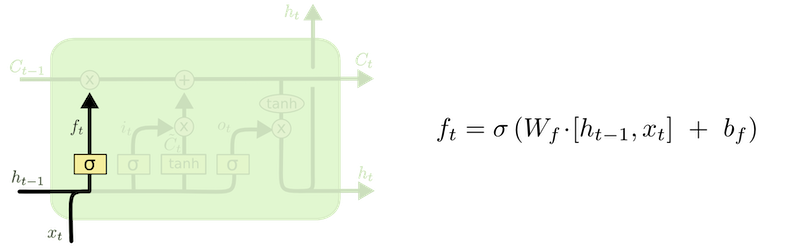

### input gate

그 다음 cell state에 현재 시점의 입력 정보를 추가하는 input gate입니다. 이는 현재 시점의 값 중 어떤 것을 cell state에 추가할 지 게이트를 거친 다음, 걸러낸 정보를 cell state에 더해줍니다. 즉, cell state에 현재 입력을 바탕으로 계산한 새로운 정보를 추가해주는 입력을 구현하게 됩니다.

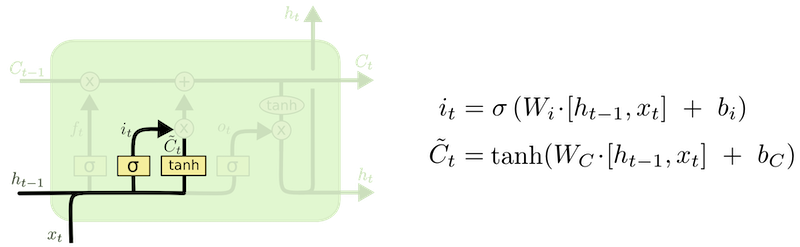

### output gate & hidden state

마지막으로 출력 게이트입니다. 이는 새롭게 구한 cell state와 현재 시점의 입력, 이전 시점의 hidden state로 계산하여 새로운 hidden state를 구합니다. 그리고 이를 출력으로 내주고, 다음 시점으로 전달해줍니다.

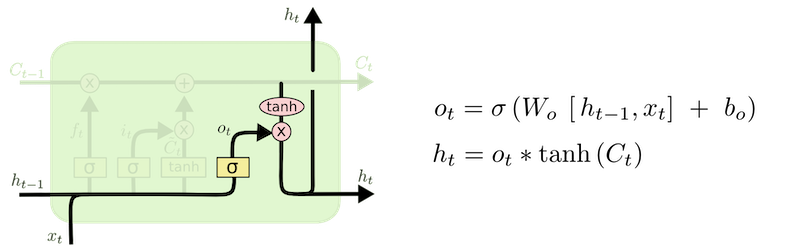

## 실습 사전 작업

이제 LSTM을 이용해서 문장 분류 모델을 학습시켜 보겠습니다. 데이터 셋을 불러오고, 토크나이저와 데이터 셋, 데이터 로더를 작성하겠습니다.

### 데이터 셋 준비

In [3]:
import pandas as pd

train_df = pd.read_csv("./drive/MyDrive/dscamp_2023/naver_reviews_train.csv")
val_df = pd.read_csv("./drive/MyDrive/dscamp_2023/naver_reviews_test.csv")

In [4]:
train_df = train_df.dropna()
val_df = val_df.dropna()

### tokenizer 준비

In [5]:
!pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.0 MB/s eta 0:00:00


In [6]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./drive/MyDrive/dscamp_2023/tokenizer.json")

### Dataset

In [7]:
from torch.utils.data import Dataset

class CustomTextDataset(Dataset):
    def __init__(self, corpus_df, transform=None):
        self.corpus_df = corpus_df
        self.transform = transform

    def __len__(self):
        return len(self.corpus_df)

    def __getitem__(self, idx):
        text, label = self.corpus_df.iloc[idx]
        return text, label

In [8]:
train_dataset = CustomTextDataset(train_df)
val_dataset = CustomTextDataset(val_df)

### DataLoader

dataloader 구현 시에 배치 내 각 문장별 토큰 개수를 집계한 batch_lengths를 추가로 리턴해주도록 합니다. 이는 RNN 학습 시에 pack_padded_sequence를 사용하기 위함이입니다.

In [9]:
MAX_TOKENS = 256
BATCH_SIZE = 128

In [10]:
vocabs = tokenizer.get_vocab()
pad_token = vocabs["[PAD]"]

In [11]:
import torch
from torch.nn.utils.rnn import pad_sequence

def _tokenize(text):
    tokens = tokenizer.encode(text).ids
    tokens = tokens[:MAX_TOKENS]
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    return token_tensor

def collate_fn(batch):
    batch_text = [x[0] for x in batch]
    batch_label = torch.tensor([x[1] for x in batch], dtype=torch.long)
    batch_tokens = [_tokenize(x) for x in batch_text]
    batch_lengths = torch.tensor([len(x) for x in batch_tokens])
    batch_padded = pad_sequence(batch_tokens, padding_value=pad_token)
    return batch_padded, batch_label, batch_lengths

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

In [13]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [14]:
train_iterator = iter(train_dataloader)
batch = next(train_iterator)
print(batch)

(tensor([[4893, 5096, 2025,  ..., 4881, 9050, 4876],
        [7921, 4873, 7346,  ..., 6601, 2677, 7311],
        [6453, 5370,    7,  ..., 5117, 1276, 6063],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]]), tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1]), tensor([24,  9,  4, 21, 13,  5, 16, 13, 13, 14,  5,  1, 14, 16, 11, 19, 10,  7,
        39, 58, 10, 16, 85,  8, 13, 17,  5,  7, 16,  5,  7, 35, 26,  5, 12, 38,
        10,  4, 15, 16, 19,  9, 14, 17, 11, 17,  6, 15, 18,  4,  3, 62,  9, 11

## LSTM 문장 분류 모델 학습

이제 RNN을 이용해서 문장을 분류하는 모델을 만들고, 이를 학습시켜보겠습니다. LSTM도 RNN과 마찬가지로 상태 값을 양방향으로 흐르도록 설정할 수 있습니다. 그리고 여러 층을 쌓을 수 있습니다. 한번 bidirectional=True, num_layers=2로 설정해서 모델을 학습시켜 보겠습니다.

전반적인 구조는 아래와 같습니다.

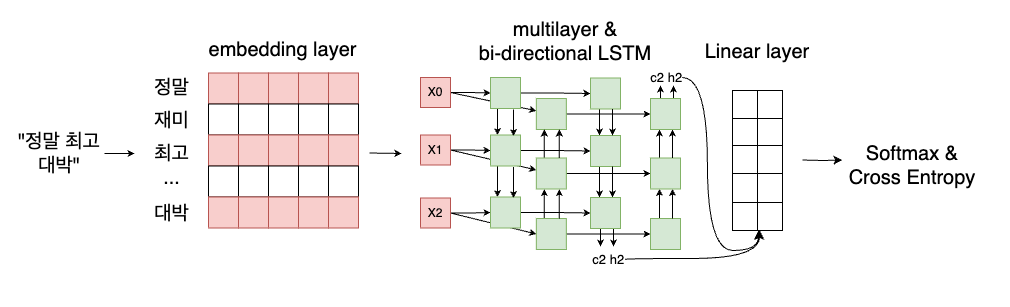

### 모델 작성

In [60]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, bidirectional, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=0.5
        )
        if bidirectional:
            self.fc = nn.Linear(2 * hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, text_lengths):
        embedded = self.dropout(self.embedding(x))
        packed_embedded = pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

In [35]:
VOCAB_SIZE = len(tokenizer.get_vocab())
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
OUTPUT_DIM = 2

In [45]:
model = LSTMModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=2,
    output_dim=OUTPUT_DIM,
    bidirectional=True
)

### 학습 코드 준비

In [46]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [47]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train, lengths in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train, lengths)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [48]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val, lengths in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val, lengths)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [49]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [50]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

### 하이퍼 파라미터 셋팅

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

In [52]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 학습

100%|██████████| 391/391 [00:07<00:00, 51.64it/s]


epoch 1 train - loss: 0.5642 acc: 0.6966 val - loss: 0.4229 acc: 0.8055


100%|██████████| 391/391 [00:07<00:00, 53.51it/s]


epoch 2 train - loss: 0.4462 acc: 0.7905 val - loss: 0.3855 acc: 0.8283


100%|██████████| 391/391 [00:07<00:00, 52.07it/s]


epoch 3 train - loss: 0.4014 acc: 0.8154 val - loss: 0.3649 acc: 0.8407


100%|██████████| 391/391 [00:07<00:00, 52.73it/s]


epoch 4 train - loss: 0.3739 acc: 0.8313 val - loss: 0.3559 acc: 0.8461


100%|██████████| 391/391 [00:07<00:00, 54.30it/s]


epoch 5 train - loss: 0.3577 acc: 0.8391 val - loss: 0.3476 acc: 0.8499


100%|██████████| 391/391 [00:07<00:00, 53.80it/s]


epoch 6 train - loss: 0.3457 acc: 0.8465 val - loss: 0.3421 acc: 0.8512


100%|██████████| 391/391 [00:07<00:00, 54.20it/s]


epoch 7 train - loss: 0.3362 acc: 0.851 val - loss: 0.3384 acc: 0.8527


100%|██████████| 391/391 [00:07<00:00, 54.21it/s]


epoch 8 train - loss: 0.3282 acc: 0.8548 val - loss: 0.3338 acc: 0.855


100%|██████████| 391/391 [00:07<00:00, 52.21it/s]


epoch 9 train - loss: 0.3228 acc: 0.8577 val - loss: 0.3479 acc: 0.854


100%|██████████| 391/391 [00:07<00:00, 53.16it/s]


epoch 10 train - loss: 0.3167 acc: 0.8608 val - loss: 0.3406 acc: 0.8555


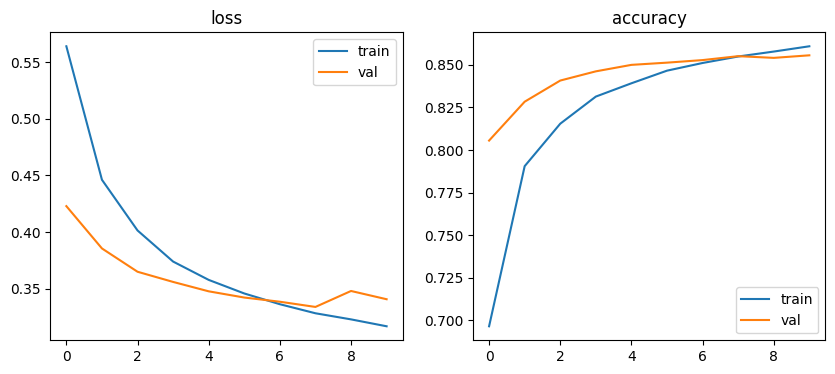

In [53]:
logs = train_validate_model(model)
plot_logs(logs)

## GRU를 이용한 문장 분류



### GRU 기본 구조
Gated Recurrent Unit의 약자로, LSTM의 약점을 보완한 모델입니다. LSTM은 다음 셀로 cell state와 hidden_state 2가지 상태 값을 넘겨주었습니다. GRU는 이것이 불필요하다고 판단하여 제거하고, hidden_state 하나만 넘겨주는 간소화 된 모델입니다.

계산 수식은 몹시 복잡하지만, 모두 기억하지 않아도 됩니다. LSTM을 간소화 하였지만 성능은 비슷하거나 오히려 더 뛰어난 모델이라는 것만 짚고 넘어가겠습니다.

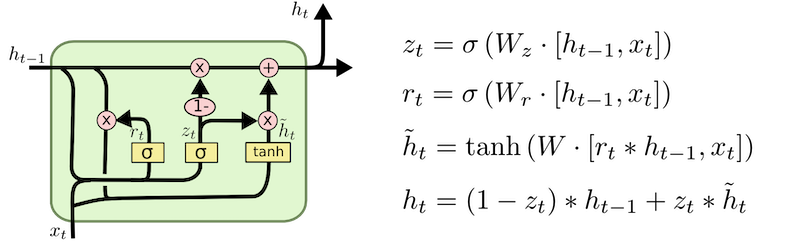

### GRU 모델 작성 및 학습

GRU는 다음 셀로 hidden_state 하나만 넘겨주면 되므로, vanila RNN과 코드 구현이 거의 동일합니다. 기존 RNN을 GRU로만 바꿔주면 됩니다. 구조는 아래와 같습니다.

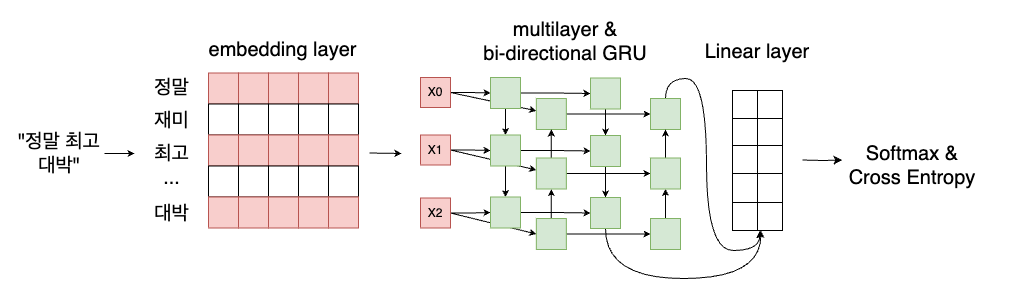

In [54]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, bidirectional, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=0.5
        )
        if bidirectional:
            self.fc = nn.Linear(2 * hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, text_lengths):
        embedded = self.dropout(self.embedding(x))
        packed_embedded = pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

GRU도 마찬가지로 bidirectional=True, num_layers는 2로 설정하여 학습시켜 보겠습니다.

In [55]:
model = GRUModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=2,
    output_dim=OUTPUT_DIM,
    bidirectional=True
)

In [58]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 391/391 [00:07<00:00, 55.12it/s]


epoch 1 train - loss: 0.5756 acc: 0.6892 val - loss: 0.4392 acc: 0.7963


100%|██████████| 391/391 [00:07<00:00, 54.91it/s]


epoch 2 train - loss: 0.4483 acc: 0.7886 val - loss: 0.3784 acc: 0.8283


100%|██████████| 391/391 [00:07<00:00, 55.00it/s]


epoch 3 train - loss: 0.4003 acc: 0.8169 val - loss: 0.3604 acc: 0.84


100%|██████████| 391/391 [00:07<00:00, 53.27it/s]


epoch 4 train - loss: 0.3732 acc: 0.8302 val - loss: 0.3475 acc: 0.8471


100%|██████████| 391/391 [00:07<00:00, 53.60it/s]


epoch 5 train - loss: 0.3558 acc: 0.8395 val - loss: 0.3506 acc: 0.8499


100%|██████████| 391/391 [00:07<00:00, 55.77it/s]


epoch 6 train - loss: 0.3459 acc: 0.8447 val - loss: 0.346 acc: 0.8538


100%|██████████| 391/391 [00:07<00:00, 54.93it/s]


epoch 7 train - loss: 0.3363 acc: 0.8506 val - loss: 0.333 acc: 0.855


100%|██████████| 391/391 [00:07<00:00, 54.84it/s]


epoch 8 train - loss: 0.3277 acc: 0.8546 val - loss: 0.3397 acc: 0.8553


100%|██████████| 391/391 [00:07<00:00, 54.83it/s]


epoch 9 train - loss: 0.3218 acc: 0.858 val - loss: 0.3359 acc: 0.8562


100%|██████████| 391/391 [00:07<00:00, 55.15it/s]


epoch 10 train - loss: 0.316 acc: 0.8602 val - loss: 0.3417 acc: 0.8565


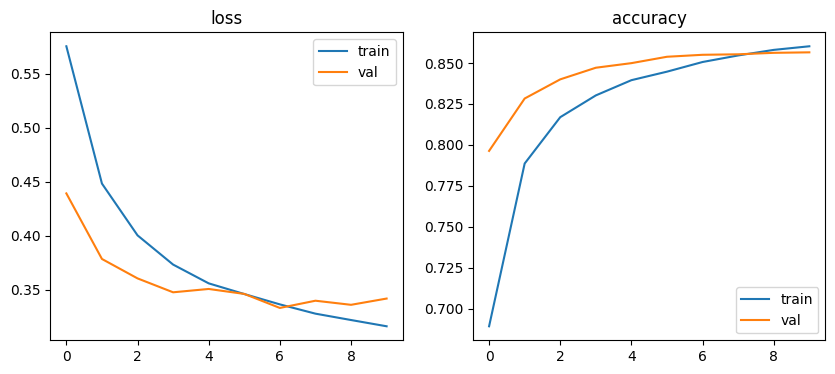

In [59]:
logs = train_validate_model(model)
plot_logs(logs)

## 정리

이번 챕터에서는 장기 기억을 저장할 수 있는 LSTM 모델에 대해서 알아보았습니다. 특히나 긴 sequence를 다룰 때에는 vanila RNN 보다 LSTM 혹은 GRU를 많이 사용합니다. 구조가 많이 복잡했지만, 실제 사용하는 방법은 어렵지 않았습니다.

너무 수식 하나하나에 매달리지 말고, 장기 기억을 저장하기 위한 구조라는 점만 기억하고 넘어가겠습니다.